In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2


In [34]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
data_path = root_path + 'DM-PROJECT/Uttrakhand_dishes'
data_path


'/content/drive/MyDrive/DM-PROJECT/Uttrakhand_dishes'

In [36]:
os.listdir(data_path)


['Thechwani',
 'Roat',
 'Singori',
 'Phaanu',
 'Thhatwani',
 'Kandaali Ka Saag',
 'Jhangora Ki Kheer',
 'Kafuli',
 'Gulgula',
 'Kumaoni Raita',
 'Chainsoo',
 'Garhwal Ka Fannah',
 'Bhang Ki Chutney',
 'Gahat Soup',
 'Baadi',
 'Dubuk',
 'Bal Mithai',
 'Aloo Gutook',
 'Arsa',
 'Aaloo Tamatar Ka Jhol']

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)


In [38]:
training_set = train_datagen.flow_from_directory(
    data_path,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

test_set = train_datagen.flow_from_directory(
    data_path,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 14567 images belonging to 20 classes.
Found 4845 images belonging to 20 classes.


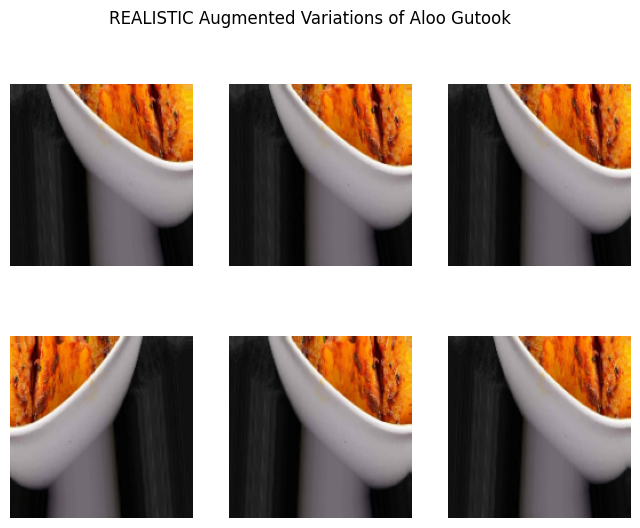

In [39]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


sample_class = random.choice(os.listdir(data_path))
sample_path = os.path.join(data_path, sample_class)
sample_image = random.choice(os.listdir(sample_path))

img = load_img(os.path.join(sample_path, sample_image), target_size=(160, 160))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)


preview_gen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.02,
    width_shift_range=0.02,
    height_shift_range=0.02,
    horizontal_flip=True
)

plt.figure(figsize=(8, 6))
i = 0

for batch in preview_gen.flow(x, batch_size=1):
    plt.subplot(2, 3, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    i += 1
    if i == 6:
        break

plt.suptitle(f"REALISTIC Augmented Variations of {sample_class}")
plt.show()


In [40]:
print("Training images:", training_set.samples)
print("Validation images:", test_set.samples)


Training images: 14567
Validation images: 4845


In [41]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3)
)

base_model.trainable = False

con = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(training_set.num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

con.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

con.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
history = con.fit(
    training_set,
    validation_data=test_set,
    epochs=12,
    steps_per_epoch=80,        # MUCH faster
    validation_steps=20,
    verbose=1
)


Epoch 1/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 281s 4s/step - accuracy: 0.7278 - loss: 0.9506 - val_accuracy: 0.8438 - val_loss: 0.7791
Epoch 2/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.7651 - loss: 0.8174 - val_accuracy: 0.8531 - val_loss: 0.6354
Epoch 3/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.7947 - loss: 0.7386 - val_accuracy: 0.8969 - val_loss: 0.4907
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8475 - loss: 0.5779 - val_accuracy: 0.9187 - val_loss: 0.4126
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8385 - loss: 0.5361 - val_accuracy: 0.9344 - val_loss: 0.4027
Epoch 6/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8934 - loss: 0.4376 - val_accuracy: 0.9344 - val_loss: 0.3529
Epoch 7/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8907 - loss: 0.4281 - val_accuracy: 0.9594 - val_loss: 0.2339
Epoch 8/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9042 - loss: 0.3566 - val_accuracy: 0.9844 - va

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 459ms/step - accuracy: 0.9280 - loss: 0.2645 - val_accuracy: 0.9875 - val_loss: 0.1166


In [44]:
test_loss, test_accuracy = con.evaluate(test_set)

print("Test Accuracy:", test_accuracy)


303/303 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9778 - loss: 0.1544
Test Accuracy: 0.9785345792770386


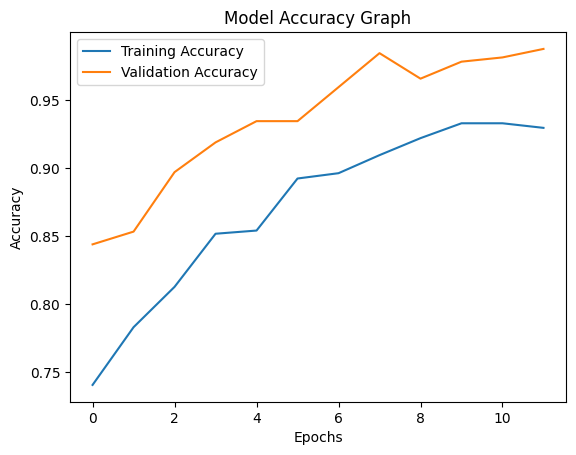

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Graph')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()


In [46]:
from tensorflow.keras.preprocessing import image

img = image.load_img(
    root_path + 'DM-PROJECT/project-test.jpeg',
    target_size=(160, 160)
)

img_array = image.img_to_array(img) / 255
img_array = np.expand_dims(img_array, axis=0)

result = con.predict(img_array)

predicted_class = np.argmax(result)
labels = list(training_set.class_indices.keys())

print("Predicted Dish:", labels[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
Predicted Dish: Gulgula


In [47]:
con.save(root_path + 'DM-PROJECT/uttrakhand_dish_model.h5')
